# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '02'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                   (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/97)
    time                      (cell) float32 ...
    q_cloud                   (cell) float32 ...
    n_cloud                   (cell) float32 ...
    q_rain                    (cell) float32 ...
    n_rain                    (cell) float32 ...
    q_ice                     (cell) float32 ...
    ...                        ...
    frze_graupel_rain_mass    (cell) float32 ...
    frze_graupel_rain_rmass   (cell) float32 ...
    frze_graupel_rain_rvol    (cell) float32 ...
    frze_graupel_rain_liq     (cell) float32 ...
    rime_graupel_rain_num     (cell) float32 ...
    rime_graupel_rain_mass    (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     So  5 Jun 2022 13:37:07 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_graupel.values
    n_s  = xr.open_dataset(fname).n_graupel.values
    r_s  = xr.open_dataset(fname).rime_graupel.values
    v_s  = xr.open_dataset(fname).rvol_graupel.values
    liq_s = xr.open_dataset(fname).liq_graupel.values
    a_s  = xr.open_dataset(fname).graupel_area.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # ice density
    rhoi = 916.7
    # reff following Fu (1996) and Foot (1988), here Eq. (3.11) of Fu (1996)
    reff = np.where(n_s>q_min,3./4.*q_s/(a_s*n_s*rhoi),np.nan)   
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)  
    liq_s = np.where(liq_s<0,np.nan,liq_s)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    reff = np.log(reff, where=reff>p_min, out=np.nan*reff)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq_s, reff ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq_s', 'reff' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  2.662984e+06  2.662984e+06  2.662984e+06  2.662984e+06  2.662984e+06   
mean  -7.562226e+00  3.985891e+00 -7.846383e+00 -1.446398e+01  1.466250e-01   
std    3.432534e+00  4.066918e+00  3.645333e+00  3.627772e+00  2.631618e-01   
min   -2.252508e+01 -1.449861e+01 -2.257248e+01 -2.763092e+01  0.000000e+00   
25%   -8.995874e+00  2.336020e+00 -9.320627e+00 -1.602533e+01  0.000000e+00   
50%   -6.623554e+00  4.870914e+00 -6.781299e+00 -1.347316e+01  1.038769e-06   
75%   -5.021413e+00  6.653185e+00 -5.162546e+00 -1.174646e+01  1.633893e-01   
max   -3.005338e+00  1.231268e+01 -3.134305e+00 -8.395064e+00  1.000000e+00   

               reff  
count  2.662984e+06  
mean  -6.701608e+00  
std    1.217121e+00  
min   -3.517537e+01  
25%   -7.503406e+00  
50%   -6.729988e+00  
75%   -6.038367e+00  
max    2.163876e-01

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s  liq_s      reff
0 -19.126671 -1.673976 -19.174299 -24.436930    0.0 -9.486160
2 -19.077400 -1.673976 -19.123919 -24.407635    0.0 -9.456775
3 -19.046076 -1.673976 -19.091715 -24.386829    0.0 -9.438832
4 -19.032082 -1.673976 -19.077669 -24.381073    0.0 -9.429260
5 -19.019609 -1.673976 -19.065189 -24.376547    0.0 -9.420513

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.864537e+06  1.864537e+06  1.864537e+06  1.864537e+06  1.864537e+06   
mean  -7.563515e+00  3.985915e+00 -7.847900e+00 -1.446537e+01  1.466990e-01   
std    3.432396e+00  4.068502e+00  3.645282e+00  3.627682e+00  2.632618e-01   
min   -2.250183e+01 -1.449861e+01 -2.254918e+01 -2.763062e+01  0.000000e+00   
25%   -8.997328e+00  2.336600e+00 -9.322725e+00 -1.602789e+01  0.000000e+00   
50%   -6.624382e+00  4.871373e+00 -6.781563e+00 -1.347405e+01  1.017955e-06   
75%   -5.023720e+00  6.654346e+00 -5.163857e+00 -1.174815e+01  1.634481e-01   
max   -3.005338e+00  1.226448e+01 -3.163583e+00 -8.395064e+00  1.000000e+00   

               reff  
count  1.864537e+06  
mean  -6.702361e+00  
std    1.217256e+00  
min   -3.517537e+01  
25%   -7.504281e+00  
50%   -6.730464e+00  
75%   -6.038489e+00  
max    2.163876e-01

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  399199.000000  399199.000000  399199.000000  399199.000000   
mean       -7.559494       3.983561      -7.843353     -14.461896   
std         3.434622       4.065700       3.648234       3.631421   
min       -22.502129     -14.498609     -22.549492     -27.629023   
25%        -8.989119       2.333114      -9.310542     -16.014772   
50%        -6.621149       4.873440      -6.781034     -13.472276   
75%        -5.018068       6.647331      -5.161516     -11.746378   
max        -3.084301      11.799232      -3.134305      -8.555779   

               liq_s           reff  
count  399199.000000  399199.000000  
mean        0.146643      -6.699051  
std         0.262882       1.214990  
min         0.000000     -25.867863  
25%         0.000000      -7.499900  
50%         0.000001      -6.728874  
75%         0.164028      -6.038650  
max         0.999813      -0.403208

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  399248.000000  399248.000000  399248.000000  399248.000000   
mean       -7.558929       3.988118      -7.842334     -14.459605   
std         3.431095       4.060742       3.642673       3.624542   
min       -22.525076     -14.498609     -22.572485     -27.630920   
25%        -8.997106       2.334253      -9.321308     -16.023968   
50%        -6.620998       4.865995      -6.779098     -13.470468   
75%        -5.016467       6.653250      -5.156154     -11.740677   
max        -3.250031      12.312682      -3.355498      -8.592240   

               liq_s           reff  
count  399248.000000  399248.000000  
mean        0.146261      -6.700645  
std         0.262975       1.218621  
min         0.000000     -28.152454  
25%         0.000000      -7.502820  
50%         0.000001      -6.728925  
75%         0.162311      -6.037525  
max         0.999788      -0.493436

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['reff'] < -14 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.861272e+06  1.861272e+06  1.861272e+06  1.861272e+06  1.861272e+06   
mean  -7.541134e+00  4.004965e+00 -7.825765e+00 -1.444392e+01  1.468088e-01   
std    3.392753e+00  4.043629e+00  3.609277e+00  3.593877e+00  2.634093e-01   
min   -1.999988e+01 -1.449861e+01 -2.190235e+01 -2.762992e+01  0.000000e+00   
25%   -8.979943e+00  2.359816e+00 -9.304255e+00 -1.600870e+01  0.000000e+00   
50%   -6.619723e+00  4.877332e+00 -6.776902e+00 -1.346951e+01  1.026240e-06   
75%   -5.020292e+00  6.657408e+00 -5.160941e+00 -1.174503e+01  1.635703e-01   
max   -3.005338e+00  1.226448e+01 -3.163583e+00 -8.395064e+00  1.000000e+00   

               reff  
count  1.861272e+06  
mean  -6.699720e+00  
std    1.211430e+00  
min   -1.377747e+01  
25%   -7.502455e+00  
50%   -6.729594e+00  
75%   -6.037407e+00  
max    2.163876e-01

In [17]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  398483.000000  398483.000000  398483.000000  398483.000000   
mean       -7.536370       4.002981      -7.820520     -14.439819   
std         3.393495       4.040338       3.610970       3.596629   
min       -19.998377     -14.498609     -22.095303     -27.629023   
25%        -8.971481       2.356979      -9.290055     -15.996586   
50%        -6.615608       4.879387      -6.774799     -13.467392   
75%        -5.014749       6.650784      -5.158451     -11.743546   
max        -3.084301      11.799232      -3.134305      -8.555779   

               liq_s           reff  
count  398483.000000  398483.000000  
mean        0.146776      -6.696443  
std         0.263042       1.210658  
min         0.000000     -13.516145  
25%         0.000000      -7.497916  
50%         0.000001      -6.728065  
75%         0.164254      -6.037708  
max         0.999813      -0.403208

### Pairplot

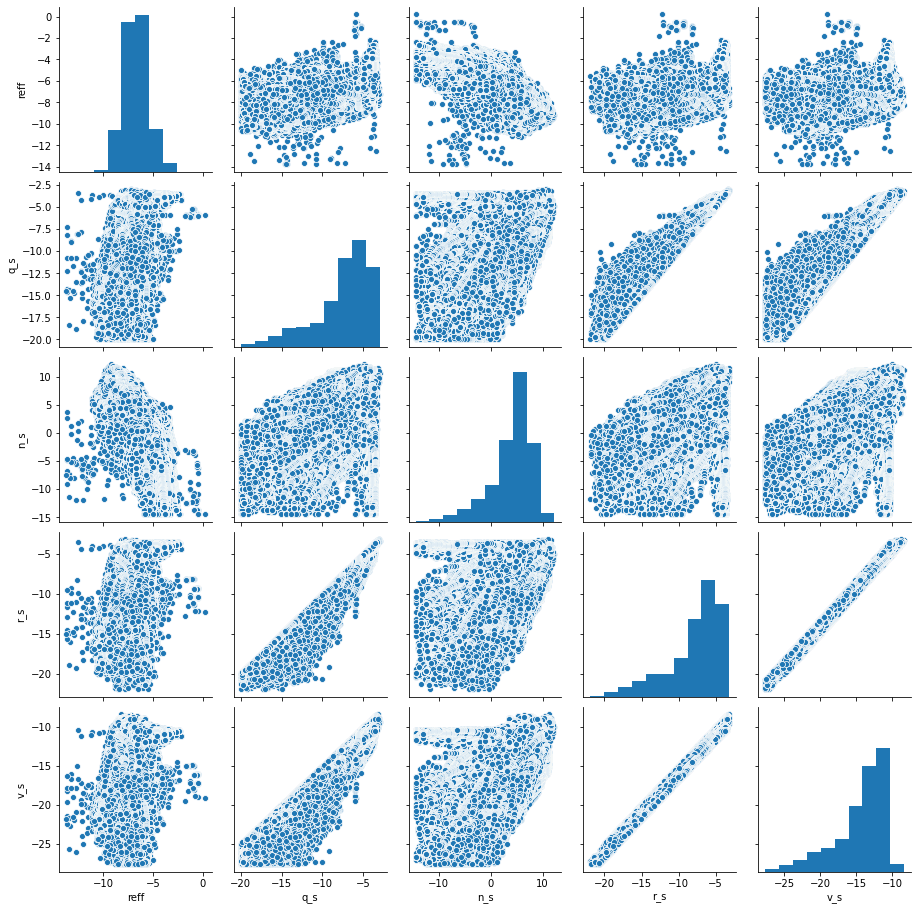

In [18]:
sns.pairplot(dataset_train[["reff","q_s","n_s","r_s","v_s"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("reff")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s    1861272.0  -7.541134  3.392753 -19.999880  -8.979943  -6.619723   
n_s    1861272.0   4.004965  4.043629 -14.498609   2.359816   4.877332   
r_s    1861272.0  -7.825765  3.609277 -21.902351  -9.304255  -6.776902   
v_s    1861272.0 -14.443915  3.593877 -27.629921 -16.008703 -13.469512   
liq_s  1861272.0   0.146809  0.263409   0.000000   0.000000   0.000001   

             75%        max  
q_s    -5.020292  -3.005338  
n_s     6.657408  12.264483  
r_s    -5.160941  -3.163583  
v_s   -11.745031  -8.395064  
liq_s   0.163570   1.000000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [23]:
# pop does not work for multiple columns, use copy instead

labels = ['reff']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [24]:
train_labels.describe()

reff
count  1.861272e+06
mean  -6.699720e+00
std    1.211430e+00
min   -1.377747e+01
25%   -7.502455e+00
50%   -6.729594e+00
75%   -6.037407e+00
max    2.163876e-01

In [25]:
train_dataset1.describe()

q_s           n_s           r_s           v_s         liq_s
count  1.861272e+06  1.861272e+06  1.861272e+06  1.861272e+06  1.861272e+06
mean  -7.541134e+00  4.004965e+00 -7.825765e+00 -1.444392e+01  1.468088e-01
std    3.392753e+00  4.043629e+00  3.609277e+00  3.593877e+00  2.634093e-01
min   -1.999988e+01 -1.449861e+01 -2.190235e+01 -2.762992e+01  0.000000e+00
25%   -8.979943e+00  2.359816e+00 -9.304255e+00 -1.600870e+01  0.000000e+00
50%   -6.619723e+00  4.877332e+00 -6.776902e+00 -1.346951e+01  1.026240e-06
75%   -5.020292e+00  6.657408e+00 -5.160941e+00 -1.174503e+01  1.635703e-01
max   -3.005338e+00  1.226448e+01 -3.163583e+00 -8.395064e+00  1.000000e+00

### Normalize the features

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_val_data1 = norm(val_dataset1,train_stats1)

In [27]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s    1861272.0 -2.318059e-08  1.0 -3.672164 -0.424083  0.271582  0.743008   
n_s    1861272.0  1.113669e-07  1.0 -4.575982 -0.406850  0.215739  0.655956   
r_s    1861272.0 -3.857836e-07  1.0 -3.900113 -0.409636  0.290602  0.738326   
v_s    1861272.0  3.092679e-07  1.0 -3.669020 -0.435404  0.271129  0.750967   
liq_s  1861272.0 -2.959646e-08  1.0 -0.557341 -0.557341 -0.557337  0.063633   

            max  
q_s    1.336907  
n_s    2.042600  
r_s    1.291722  
v_s    1.683099  
liq_s  3.239032

### Normalize the labels

In [28]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count     mean      std        min       25%       50%       75%  \
reff  1861272.0 -6.69972  1.21143 -13.777474 -7.502455 -6.729594 -6.037407   

           max  
reff  0.216388

In [29]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [30]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [31]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [33]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8286496 ],
       [-0.8287639 ],
       [-0.8288405 ],
       [-0.82886887],
       [-0.82889307],
       [-0.8289404 ],
       [-0.82948524],
       [-0.8295071 ],
       [-0.8295828 ],
       [-0.8296037 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [34]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [35]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0225,  mae:0.0838,  mse:0.0225,  val_loss:0.0145,  val_mae:0.0682,  val_mse:0.0145,  
......................................................................

Text(0, 0.5, 'MAE')

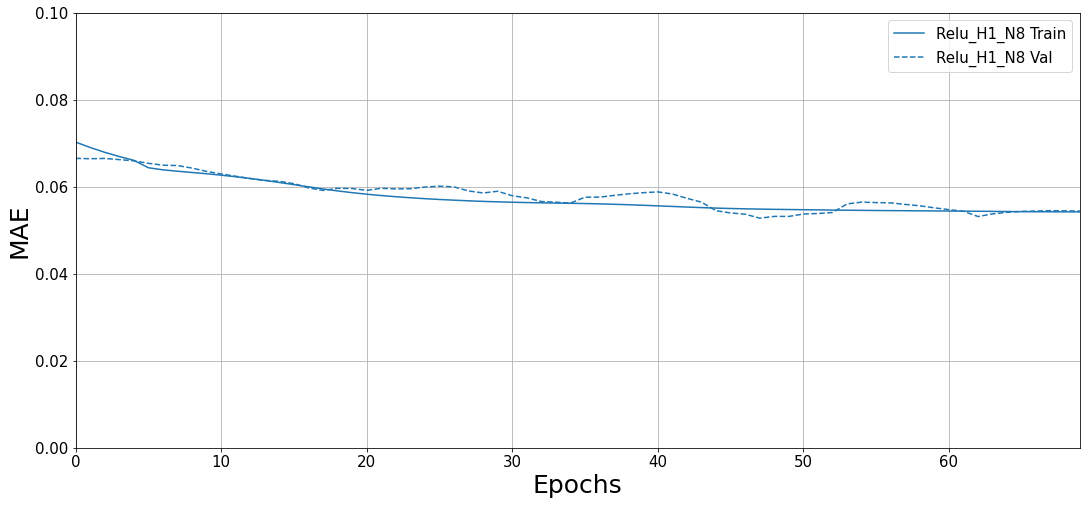

In [36]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.,0.1])
plt.ylabel('MAE')

In [37]:
nsize = 16
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0164,  mae:0.0691,  mse:0.0164,  val_loss:0.0126,  val_mae:0.0589,  val_mse:0.0126,  
..................

Text(0, 0.5, 'MAE')

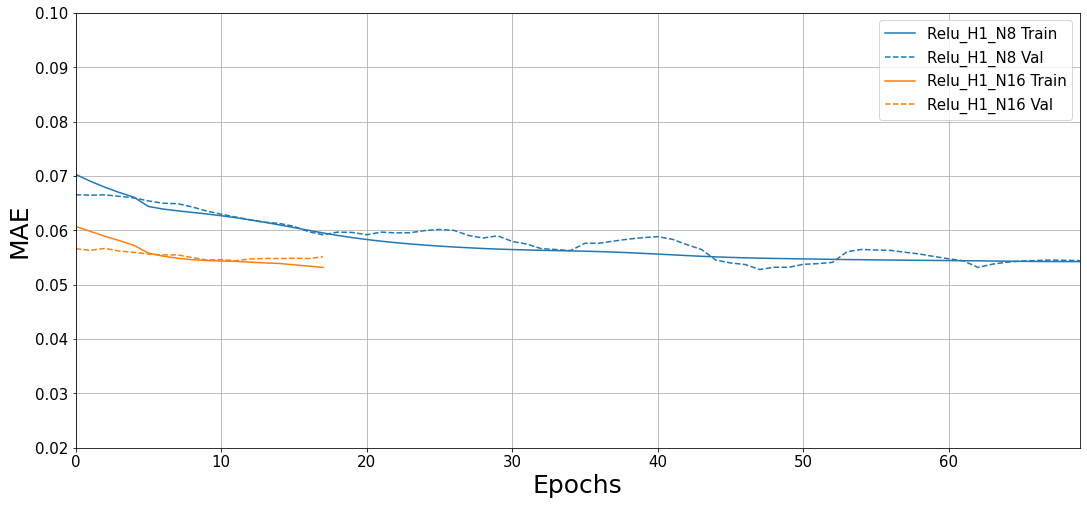

In [38]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [39]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0215,  mae:0.0823,  mse:0.0215,  val_loss:0.0145,  val_mae:0.0696,  val_mse:0.0145,  
...............................

Text(0, 0.5, 'MAE')

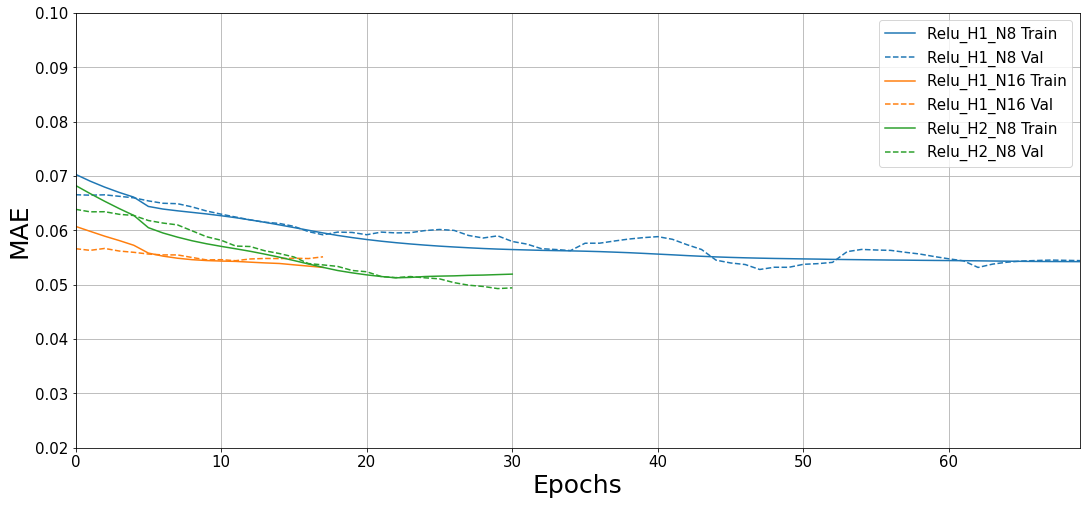

In [40]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [41]:
nsize = 16
model4 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0157,  mae:0.0689,  mse:0.0157,  val_loss:0.0124,  val_mae:0.0594,  val_mse:0.0124,  
............................................................................

Text(0, 0.5, 'MAE')

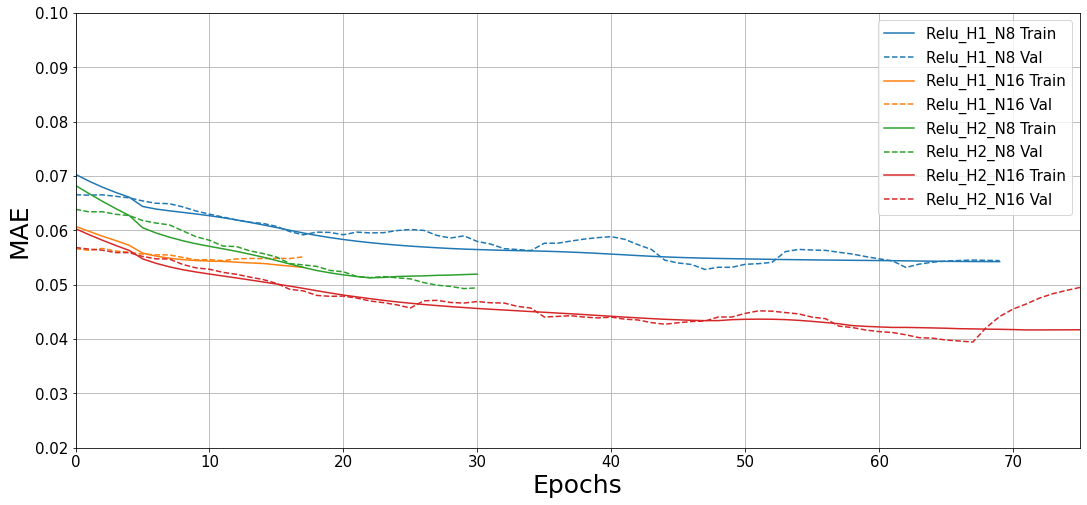

In [42]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [43]:
nsize = 32
model5 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0147,  mae:0.0656,  mse:0.0147,  val_loss:0.0126,  val_mae:0.0637,  val_mse:0.0126,  
.......................................................................................

Text(0, 0.5, 'MAE')

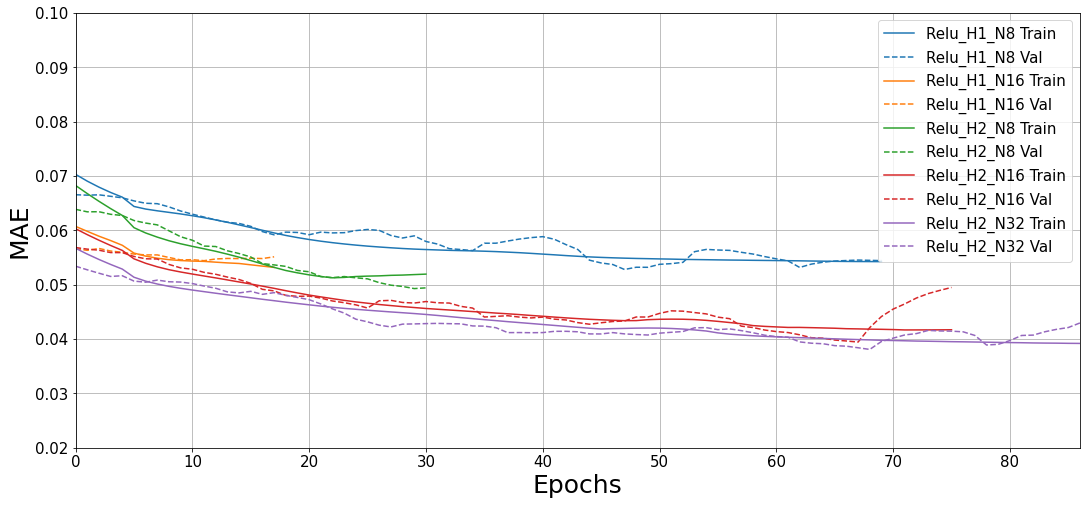

In [44]:
histories['ReLU_H2_n32'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [45]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.03])
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

In [46]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

398483/398483 - 9s - loss: 0.0086 - mae: 0.0501 - mse: 0.0086
Testing set for model 1, Mean Abs Error:    0.05007


In [47]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

398483/398483 - 9s - loss: 0.0092 - mae: 0.0498 - mse: 0.0092
Testing set for model 2, Mean Abs Error:              0.04982


In [48]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

398483/398483 - 9s - loss: 0.0078 - mae: 0.0465 - mse: 0.0078
Testing set for model 3, Mean Abs Error:              0.04647


In [49]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

398483/398483 - 9s - loss: 0.0063 - mae: 0.0381 - mse: 0.0063
Testing set for model 4, Mean Abs Error:              0.03809


In [50]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

398483/398483 - 9s - loss: 0.0059 - mae: 0.0354 - mse: 0.0059
Testing set for model 5, Mean Abs Error:              0.03545


In [51]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.050065704, 0.049817346, 0.046471138, 0.03809467, 0.035449047]

In [52]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.008598551, 0.009157075, 0.007832755, 0.0062710713, 0.00586121]

In [53]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [ 'model 1 \n H1n8',
 'model 2 \n H1n16',
 'model 3 \n H2n8',
 'model 4 \n H2n16',
 'model 5 \n H2n32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [54]:
test_true_num  = np.exp(test_labels.pop('reff'))

In [55]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [56]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

In [57]:
p1.describe()

reff
count  398483.000000
mean        0.005391
std         0.990514
min        -3.564951
25%        -0.652530
50%        -0.023969
75%         0.553564
max         4.314546

In [58]:
train_labels_stats

count     mean      std        min       25%       50%       75%  \
reff  1861272.0 -6.69972  1.21143 -13.777474 -7.502455 -6.729594 -6.037407   

           max  
reff  0.216388

In [59]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [60]:
test_predict1.describe()

reff
count  398483.000000
mean        0.002687
std         0.004533
min         0.000016
25%         0.000559
50%         0.001196
75%         0.002408
max         0.229248

In [61]:
test_predict1_num  = test_predict1['reff']

In [62]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=["reff"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['reff']

In [63]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data1), columns=["reff"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['reff']

In [64]:

p5 = pd.DataFrame(data=model5.predict(normed_test_data1), columns=["reff"])

test_predict5 = np.exp(backtransform(p5,train_labels_stats))

test_predict5_num  = test_predict5['reff']

### Maybe the ordering of the arrays is different? 

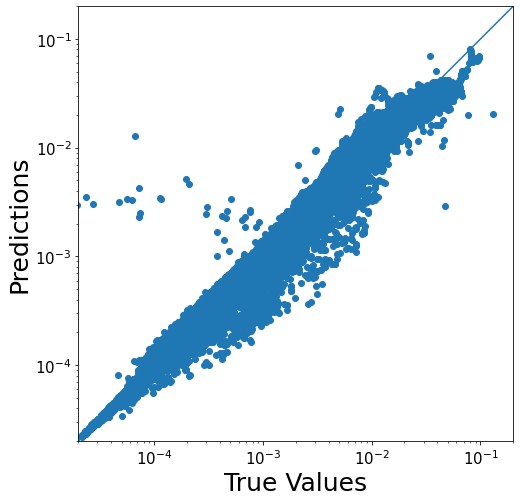

In [65]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 2e-5, 2e-1

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [66]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

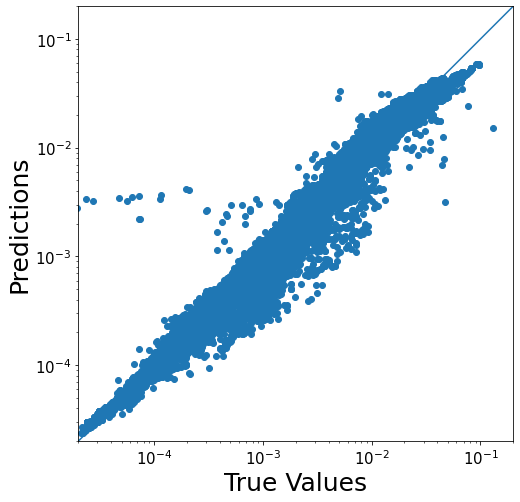

In [67]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

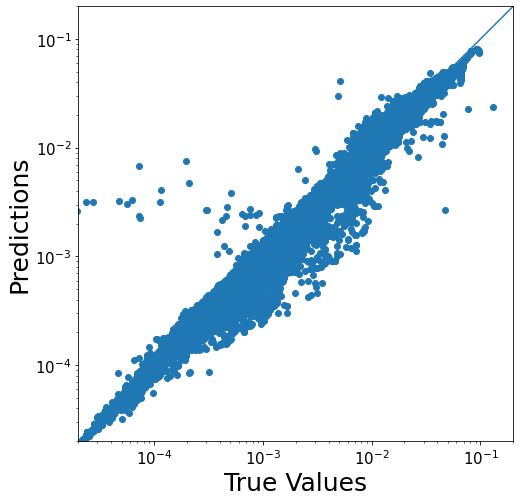

In [68]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict5_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [69]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [70]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [71]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liquid_graupel'
labels   = 'reff_graupel'
filename = 'saved_model_v2/reff_graupel_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_graupel_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_graupel_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_graupel_model4_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_graupel_model5_'+version+'.nc')




Saving model to saved_model_v2/reff_graupel_model1_02.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liquid_graupel
  Labels:     reff_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/reff_graupel_model2_02.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liquid_graupel
  Labels:     reff_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/reff_graupel_model3_02.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liquid_g

In [72]:
train_stats1

count       mean       std        min        25%        50%  \
q_s    1861272.0  -7.541134  3.392753 -19.999880  -8.979943  -6.619723   
n_s    1861272.0   4.004965  4.043629 -14.498609   2.359816   4.877332   
r_s    1861272.0  -7.825765  3.609277 -21.902351  -9.304255  -6.776902   
v_s    1861272.0 -14.443915  3.593877 -27.629921 -16.008703 -13.469512   
liq_s  1861272.0   0.146809  0.263409   0.000000   0.000000   0.000001   

             75%        max  
q_s    -5.020292  -3.005338  
n_s     6.657408  12.264483  
r_s    -5.160941  -3.163583  
v_s   -11.745031  -8.395064  
liq_s   0.163570   1.000000